**Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

%matplotlib inline

**Define Dataframe and Pairs**

In [ ]:
A = 'PG'
B = 'KMB'
pairs_tickers = [A, B]

prices_df = pd.DataFrame()
start_date = '1985-01-02'
end_date = '2014-12-31'

for ticker in pairs_tickers:
  data = yf.download(ticker, start=start_date, end=end_date)
  prices_df[ticker] = data['Adj Close']

prices_df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,PG,KMB
Date,,
1985-01-02,1.267408,1.677573
1985-01-03,1.258958,1.690747
1985-01-04,1.261776,1.664398
1985-01-07,1.278674,1.660007
1985-01-08,1.284307,1.668789
...,...,...
2014-12-23,71.727623,86.861298
2014-12-24,71.612312,86.706703
2014-12-26,71.858322,87.082191


**Plot of Prices**

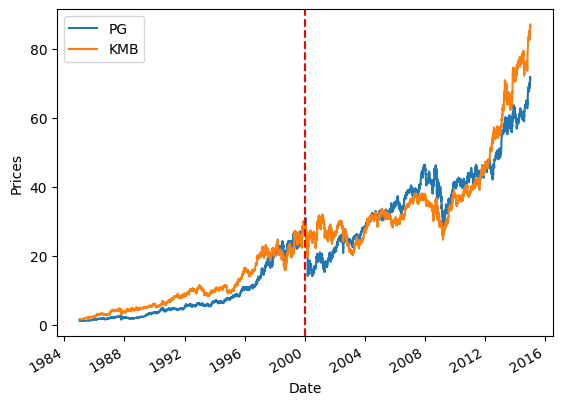

In [ ]:
ax = prices_df.plot()
plt.legend()
plt.ylabel('Prices')
ax.axvline(x='1999-12-31', color='r', linestyle='--', label='Vertical Line at 1999-12-31')
plt.show()

**OLS to get variables for HJB**

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

def traditional_least_squares(prices_df, col1, col2):
    """
    Perform traditional least squares method on two columns of data.

    Parameters:
        data (DataFrame): Input DataFrame containing the two columns.
        col1 (str): Name of the first column.
        col2 (str): Name of the second column.

    Returns:
        tuple: Tuple containing (mu1, mu2, rho11, rho22, rho12).
    """
    returns = (prices_df[[col1, col2]] - prices_df[[col1, col2]].shift(1)).dropna()

    # Separate the independent and dependent variables
    X = returns[col1].values.reshape(-1, 1)
    y = returns[col2].values

    # Fit linear regression model
    model = LinearRegression().fit(X, y)

    # Calculate mu1
    μ1 = returns[col1].mean()

    # Calculate mu2 and rho12 from the linear regression coefficients
    μ2 = model.intercept_
    σ12 = model.coef_[0]

    # Calculate residuals
    residuals = y - model.predict(X)

    # Calculate rho11 and rho22 from the residuals
    σ11 = np.var(residuals)
    σ22 = np.var(returns[col2] - μ2 * returns[col1])

    return μ1, μ2, σ11, σ12, σ22

In [ ]:
μ1, μ2, σ11, σ12, σ22 = (traditional_least_squares(prices_df.loc[:'1999-12-31'], A, B))

μ1 = round(μ1,4)
μ2 = round(μ2,4)
σ11 = round(σ11,4)
σ12 = round(σ12,4)
σ22 = round(σ22,4)


# Print the results
print("μ1:", μ1)
print("μ2:", μ2)
print("σ11:", σ11)
print("σ12:", σ12)
print("σ22:", σ22)

μ1: 0.0073
μ2: 0.0048
σ11: 0.0461
σ12: 0.3195
σ22: 0.0498


In [ ]:
prices_df.loc[:'1999-12-31']

,PG,KMB
Date,,
1985-01-02,1.267408,1.677573
1985-01-03,1.258958,1.690747
1985-01-04,1.261776,1.664398
1985-01-07,1.278674,1.660007
1985-01-08,1.284307,1.668789
...,...,...
1999-12-27,29.304583,28.676859
1999-12-28,28.925714,28.322826
1999-12-29,28.826876,28.377291


**Calculate spread**

In [ ]:
spread = prices_df[A] - prices_df[B]
spread

Date
1985-01-02    -0.410165
1985-01-03    -0.431789
1985-01-04    -0.402623
1985-01-07    -0.381332
1985-01-08    -0.384482
                ...    
2014-12-23   -15.133675
2014-12-24   -15.094391
2014-12-26   -15.223869
2014-12-29   -15.235832
2014-12-30   -15.354134
Length: 7563, dtype: float64

**Calculate z-score**

In [ ]:
spread_mean = spread.mean()
spread_std = spread.std()
spread_zscore = (spread - spread_mean) / spread_std
spread_zscore

Date
1985-01-02    0.269599
1985-01-03    0.265091
1985-01-04    0.271171
1985-01-07    0.275609
1985-01-08    0.274953
                ...   
2014-12-23   -2.799540
2014-12-24   -2.791351
2014-12-26   -2.818341
2014-12-29   -2.820835
2014-12-30   -2.845495
Length: 7563, dtype: float64

**Calculate a11, a22, a12, lambda**

In [ ]:
ρ = 0.05
a11 = round(σ11 ** 2 + σ12 ** 2, 4)
a22 = round(σ22 ** 2 + σ12 ** 2, 4)
a12 = round(σ12 * (σ11 + σ22), 4)
λ = round((a11 - 2*a12 + a22) / 2, 4)

print("a11:", a11)
print("a22:", a22)
print("a12:", a12)
print("λ:", λ)

a11: 0.1042
a22: 0.1046
a12: 0.0306
λ: 0.0738


In [ ]:
c1 = round(1 + (μ1-μ2)/λ, 4)
c2 = round(4 * (ρ-μ1)/λ, 4)
c3 = round((c1 ** 2 + c2) ** 0.5, 4)

print("c1:", c1)
print("c2:", c2)
print("c3:", c3)

c1: 1.0339
c2: 2.3144
c3: 1.8394


**Calculate delta 1 and delta 2**

In [ ]:
δ1 = round(0.5 * (c1 + c3), 4)
δ2 = round(0.5 * (c1 - c3), 4)

print("δ1:", δ1)
print("δ2:", δ2)

δ1: 1.4366
δ2: -0.4027


**Initialize transaction costs**

In [ ]:
K = 0.001
βb = 1 + K
βs = 1 - K
β2 = round((βb / βs)**2, 6)


print("K:", K)
print("βb:", βb)
print("βs:", βs)
print("β^2:", β2)

K: 0.001
βb: 1.001
βs: 0.999
β^2: 1.004008


**Calculate r0 such that f(r) is 0 and r0 > β^2**

In [ ]:
r0 = 1.225 # By Newton Raphson's Method
r0

1.225

**Calculate k1 and k2**

In [ ]:
term1 = δ2 * (βb * (r0 ** (-δ1)) - βs)
term2 = (1 - δ2) * (βb - βs * (r0 ** (1 - δ1)))
term3 = δ2 * (βb * (r0 ** (1-δ1)) - βs * r0)

k1 = round(term1 / term2, 4)
k2 = round(term3 / term2, 4)

print("k1:", k1)
print("k2:", k2)

k1: 0.8315
k2: 1.0186


**Calculate k1x1 and k2x1, x1=price of stock A**

In [ ]:
df = prices_df.loc['1999-12-31':, :].copy()
df['k2x1'] = k2 * df[A]
df['k1x1'] = k1 * df[A]

df

,PG,KMB,k2x1,k1x1
Date,,,,
1999-12-31,28.876299,28.513458,29.413398,24.010643
2000-01-03,28.250328,27.859854,28.775784,23.490148
2000-01-04,27.706743,27.614752,28.222089,23.038157
2000-01-05,27.179636,27.478600,27.685177,22.599867
2000-01-06,28.431532,27.887089,28.960358,23.640819
...,...,...,...,...
2014-12-23,71.727623,86.861298,73.061757,59.641519
2014-12-24,71.612312,86.706703,72.944301,59.545638
2014-12-26,71.858322,87.082191,73.194887,59.750195


**Determining regions based on the boundary conditions**

In [ ]:
def compare_columns(row):
    if row[B] > row['k2x1']:
        return 3
    elif row[B] < row['k2x1'] and row[B] > row['k1x1']:
        return 2
    elif row[B] < row['k1x1']:
        return 1
df['Region'] = df.apply(compare_columns, axis=1)
df

,PG,KMB,k2x1,k1x1,Region
Date,,,,,
1999-12-31,28.876299,28.513458,29.413398,24.010643,2
2000-01-03,28.250328,27.859854,28.775784,23.490148,2
2000-01-04,27.706743,27.614752,28.222089,23.038157,2
2000-01-05,27.179636,27.478600,27.685177,22.599867,2
2000-01-06,28.431532,27.887089,28.960358,23.640819,2
...,...,...,...,...,...
2014-12-23,71.727623,86.861298,73.061757,59.641519,3
2014-12-24,71.612312,86.706703,72.944301,59.545638,3
2014-12-26,71.858322,87.082191,73.194887,59.750195,3


In [ ]:
df['Change'] = df['Region'].diff()
df

,PG,KMB,k2x1,k1x1,Region,Change
Date,,,,,,
1999-12-31,28.876299,28.513458,29.413398,24.010643,2,NaN
2000-01-03,28.250328,27.859854,28.775784,23.490148,2,0.0
2000-01-04,27.706743,27.614752,28.222089,23.038157,2,0.0
2000-01-05,27.179636,27.478600,27.685177,22.599867,2,0.0
2000-01-06,28.431532,27.887089,28.960358,23.640819,2,0.0
...,...,...,...,...,...,...
2014-12-23,71.727623,86.861298,73.061757,59.641519,3,0.0
2014-12-24,71.612312,86.706703,72.944301,59.545638,3,0.0
2014-12-26,71.858322,87.082191,73.194887,59.750195,3,0.0


**Plotting Regions**

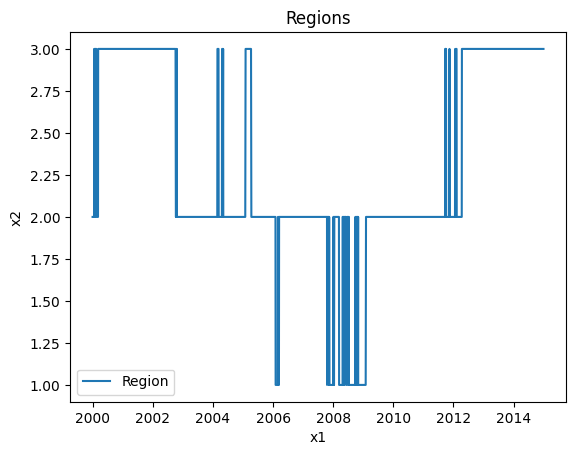

In [ ]:
plt.plot(df['Region'], label='Region')

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Regions')

plt.legend()
plt.show()

**Dropping dates where there was no trades**

In [ ]:
df = df[df['Change'] != 0]
df

,PG,KMB,k2x1,k1x1,Region,Change
Date,,,,,,
1999-12-31,28.876299,28.513458,29.413398,24.010643,2,NaN
2000-01-21,27.138578,28.186655,27.643356,22.565728,3,1.0
2000-01-24,27.254221,27.478600,27.761149,22.661885,2,-1.0
2000-01-25,25.767609,27.124557,26.246886,21.425767,3,1.0
2000-01-31,26.709122,27.070095,27.205911,22.208635,2,-1.0
...,...,...,...,...,...,...
2012-01-23,45.813320,46.926987,46.665448,38.093776,3,1.0
2012-01-24,45.460911,46.129120,46.306484,37.800747,2,-1.0
2012-01-30,44.551697,45.535530,45.380358,37.044736,3,1.0


**Calculating shares and capital**

In [ ]:
initial_capital = 100000

shares_A = []
shares_B = []
capital = [initial_capital]

for i in range(len(df)):
    if df['Region'].iloc[i] == 3:
        shares_A.append(capital[-1] / (2*df[A].iloc[i]))
        shares_B.append(-capital[-1] / (2*df[B].iloc[i]))
    elif df['Region'].iloc[i] == 1:
        shares_A.append(-capital[-1] / (2*df[A].iloc[i]))
        shares_B.append(capital[-1] / (2*df[B].iloc[i]))
    elif df['Region'].iloc[i] == 2:
        if i > 0 and len(shares_A) > 0 and len(shares_B) > 0:
            capital_change = ((df[A].iloc[i] - df[A].iloc[i-1]) * shares_A[-1] + (df[B].iloc[i] - df[B].iloc[i-1]) * shares_B[-1])
            capital.append(capital[-1] + capital_change)

print("Shares A:", shares_A)
print("Shares B:", shares_B)
print("Capital:", capital)

Shares A: [1842.3956935237625, 1968.9268154908077, 1966.5352398943737, 3240.0731503972484, 2331.2850798248714, 2342.963855995601, 2045.32934884273, 2014.8042446063469, 1970.9809746227766, 1960.1553341605286, -1741.8005873449338, -1731.6351135139619, -1432.4304971244871, -1462.9559901414957, -1453.1898719698515, -1436.92564135928, -1454.9368999712951, -1578.6768094816337, -1578.4290943753836, -1615.1346120982998, -1596.5099710556156, -1627.5096349793862, -1723.5143502134813, -1703.7577601836808, -1571.40022756445, -1724.3142373807696, -1848.7357249623055, -1787.2363379602757, -1769.1282463573607, 1724.875864192651, 1670.0694713730315, 1679.29250526415, 1620.1585601376019, 1673.7939362679822, 1605.307596398247]
Shares B: [-1773.889094713906, -1870.428140130128, -1927.7678185195623, -2641.8888006421707, -2262.4921853436003, -2287.788611850565, -1994.0313635699192, -1972.27266115881, -1925.1181953309597, -1894.3578767347242, 2130.3879712966063, 2093.1849744484743, 1750.935754449427, 1765.6

**Adding these to the df**

In [ ]:
df = df[df['Region'] != 2]
df['Shares_A'] = shares_A
df['Shares_B'] = shares_B
df['Capital'] = capital
df.drop(columns=['Region', 'Change'], inplace=True)
df

<ipython-input-21-e724f54f5eca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Shares_A'] = shares_A
<ipython-input-21-e724f54f5eca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Shares_B'] = shares_B
<ipython-input-21-e724f54f5eca>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

,PG,KMB,k2x1,k1x1,Shares_A,Shares_B,Capital
Date,,,,,,,
2000-01-21,27.138578,28.186655,27.643356,22.565728,1842.395694,-1773.889095,100000.000000
2000-01-25,25.767609,27.124557,26.246886,21.425767,1968.926815,-1870.428140,101469.071255
2000-02-01,26.296175,26.824991,26.785284,21.865270,1966.535240,-1927.767819,103424.709636
2000-03-07,16.121281,19.771509,16.421136,13.404845,3240.073150,-2641.888801,104468.257299
2002-10-15,25.349470,26.120241,25.820970,21.078084,2331.285080,-2262.492185,118193.683031
2002-10-17,25.442406,26.056007,25.915634,21.155360,2342.963856,-2287.788612,119221.273933
2004-02-24,29.356798,30.112024,29.902835,24.410178,2045.329349,-1994.031364,120088.641778
2004-04-20,30.173063,30.823738,30.734282,25.088902,2014.804245,-1972.272661,121585.631931
2004-05-03,30.949776,31.687103,31.525442,25.734738,1970.980975,-1925.118195,122002.838131


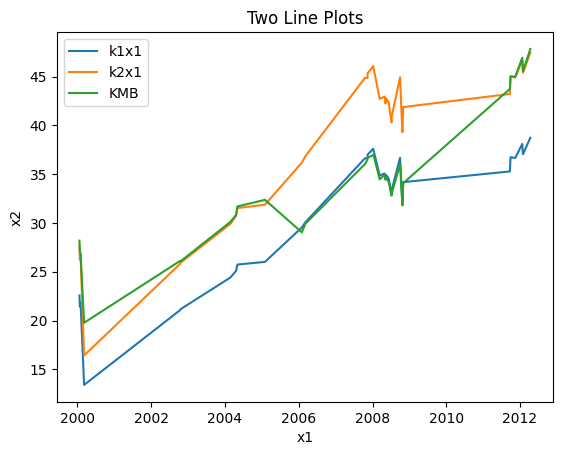

In [ ]:
plt.plot(df['k1x1'], label='k1x1')
plt.plot(df['k2x1'], label='k2x1')
plt.plot(df[B], label=B)

plt.xlabel('Date')
plt.ylabel('x2')
plt.title('Two Line Plots')

plt.legend()
plt.show()

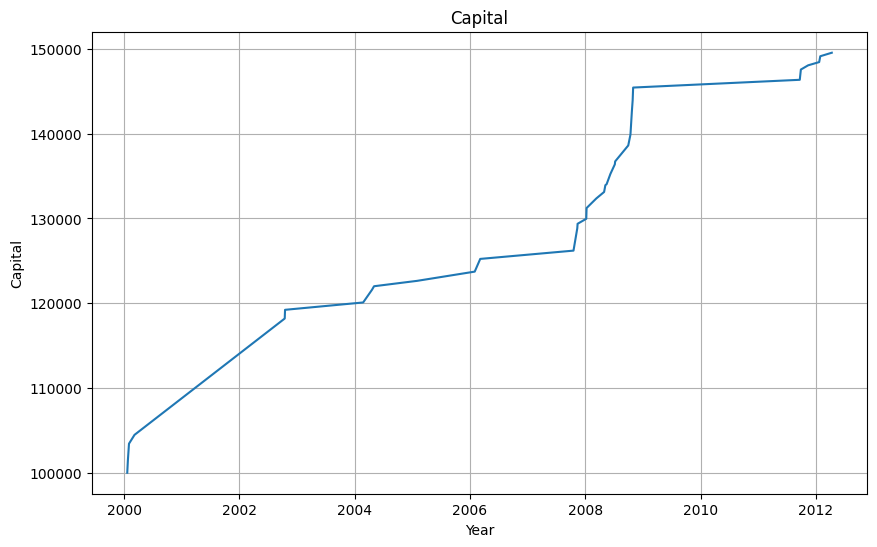

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df['Capital'])
plt.xlabel('Year')
plt.ylabel('Capital')
plt.title('Capital')
plt.grid(True)
plt.show()